# Overview

This notebook gets AOD data that was retrieved from the SPEXOne instrument aboard the PACE satellite. It combines that with $PM_{2.5}$ data collected from the EPA's Air Quality System and computes a simple linear regression.

This example is a starting point for more developing more complex models based
on the geophysical data retrieved by PACE. It's also a decent benchmark to compare your model against.

# Download Data from Earth Access

* To download the data, you must have an earthdata account. An account is free
  to sign up for. You can register for an account here: https://urs.earthdata.nasa.gov/.
* Before downloading, you will be given an estimate of the number of results
  and an estimate of the total disk space required. You will be prompted if you wish to continue to download.
* The `data_dir` parameter specifies where to save the data. If you are using
  Git or some other VCS, consider adding this value to your `.gitignore` file or
  equivalent.
* If your data directory is already populated, this step is skipped. To fetch
  a new set of data, you must delete your data directory or specify a new 
  one. 

In [1]:
import os
from pathlib import Path
from pprint import pprint

import earthaccess

## Defining the Data to Download by Using the Query Parameters

* Query parameters for earthdata are described [here](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html).
* The default query selects satellite passes that contain the NCSU campus.

In [2]:
data_dir = Path("../data/spexone")
query=dict(
    short_name="PACE_SPEXONE_L2_AER_RTAPLAND",
    version="3.0",
    point=(-78.67, 35.75) 
)

In [3]:
if os.path.isdir(data_dir):
    print(f"{data_dir} exists. Skipping earthaccess query and download.")
    results=None
else:
    earthaccess.login()
    results = earthaccess.search_data(**query)
    size = sum([r['size'] for r in results])
    print(len(results), f"results were found that matched the following query: ")
    pprint(query)
    print(f"Total size of data is {size:.2f} MB.")

../data/spexone exists. Skipping earthaccess query and download.


In [4]:
if results:
    proceed = input("Proceed? y[n]") or "n"
    if proceed.lower() == "y" or proceed.lower() == "yes":
        earthaccess.download(results,data_dir)

# Load the Data

Use the `SpexOne.from_netcdf()` to load a single file from disk. This creates an
instance of the `Satellite` class that defines an interface to satellite-based
data. You can use `SpexOne.from_netcdf()` in a loop to load several files. For
SPEXOne data, each file represents a single pass of the satellite over a
five-minute interval.

For most of this notebook, we look into the details of a single pass to see what kind of data we can expect. The `satpass` variable contains that instance.

In [5]:
from aerichor.satellite.pace import SpexOne
files=[Path(data_dir) / file for file in os.listdir(data_dir)]
passes=[SpexOne.from_netcdf(file) for file in files]
satpass=passes[0]

Use `show_swath()` to see the area covered by the satellite's pass.

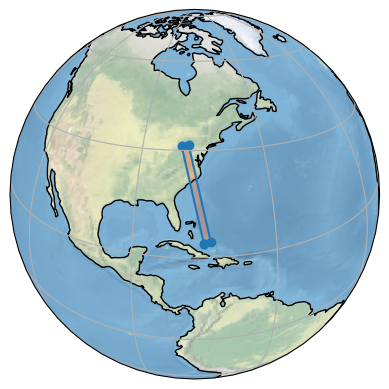

In [6]:
satpass.show_swath()

The `satpass` variable is an instance of a `Satellite` class. The `Satellite`
class is defined by two main features. The spatial and temporal characteristics of the satellite pass, (which behind the scenes is called the `Swath`) and the data, which is stored in the `data` attribute. 

In [7]:
type(satpass.data)

xarray.core.datatree.DataTree

In [8]:
geophysical_variables = [f"{key}: {value.long_name}" for key, value in satpass.data['geophysical_data'].data_vars.items()]
pprint(geophysical_variables)

['wind_speed: Wind speed',
 'wind_speed_uncertainty: Uncertainty of wind speed',
 'chla: Chlorophyll-a concentration',
 'chla_uncertainty: Uncertainty of Chlorophyll-a concentration',
 'bpdf_scale: Bi-directional surface polarization distribution function '
 'scaling parameter',
 'bpdf_scale_uncertainty: Uncertainty of bi-directional surface polarization '
 'distribution function scaling parameter',
 'bpdf_nu: Bi-directional surface polarization distribution function '
 'exponential (nu) parameter',
 'bpdf_nu_uncertainty: Uncertainty of bi-directional surface polarization '
 'distribution function exponential (nu) parameter',
 'waterfrac_inland: Water fraction for pixel over land',
 'waterfrac_inland_uncertainty: Uncertainty of water fraction for pixel over '
 'land',
 'windspeed_inland: Water wind speed for pixel over land',
 'windspeed_inland_uncertainty: Uncertainty of water wind speed for pixel over '
 'land',
 'li_sparse: Bi-directional surface reflectance distribution function '


# Fetch Data from AQS

You must have a (free) AQS account. You can initiate the signup process from the
API by running 

``` python
from aerichor.ground.aqs import AqsClient
AqsClient.signup("your.email@whatever.com")
```

The AQS service sends an email to the address that you provided. Then you can
validate your email and get the key that you need to authenticate your
credentials to use the service.

You only need to do that once. Otherwise, it's best to store your credentials in a netrc file and load them by using the `AqsClient.from_netrc()` method.

In [9]:
from aerichor.ground.aqs import AqsClient, AqiPollutant

The `get_pollutant_in_swath()` method makes a request to the AQS service. It
takes a pollutant type and a swath as an argument. Pollutant data is fetched
based on the spatial and temporal distribution of the swath. More specifically,
it fetches all the pollutant data from the day of the satellite pass where
sensors are located inside the bounding box of the swath. 

Note that the bounding box is a grid-aligned box that contains the swath. The
box is defined by the extreme latitude and longitude values. The consequence is
that for thin, diagonal swaths, there will be a lot of sensors pulled into the
data set that are not within the swath itself. (See the Appendix for more
details.)

In [10]:
api=AqsClient.from_netrc()
pm25=api.get_pollutant_in_swath(AqiPollutant.PM25, satpass)

## Investigate Anomalies; Clean Data

The result of the `get_pollutant_in_swath()` method is a `SampleDataFrame` which is a normal Pandas `DataFrame` with a few convenience functions added. You can clean the data by using normal `DataFrame` functionality.

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [12]:
pm25.head()

,site_id,longitude,latitude,time,measurement
0,0041,-76.958072,38.895572,2024-03-24 05:00:00,2.0
1,0041,-76.958072,38.895572,2024-03-24 06:00:00,2.0
2,0041,-76.958072,38.895572,2024-03-24 07:00:00,0.0
3,0041,-76.958072,38.895572,2024-03-24 08:00:00,4.0
4,0041,-76.958072,38.895572,2024-03-24 09:00:00,3.0


In [13]:
pm25.describe()

,longitude,latitude,time,measurement
count,3179.000000,3179.000000,3179,2950.000000
mean,-77.215721,38.275312,2024-03-24 16:27:36.747404800,3.634136
min,-80.316442,25.794222,2024-03-24 05:00:00,-6.000000
25%,-79.003050,37.590880,2024-03-24 10:00:00,2.800000
50%,-76.958072,39.739441,2024-03-24 16:00:00,3.400000
75%,-75.432500,40.304694,2024-03-24 22:00:00,4.600000
max,-73.927690,40.924580,2024-03-25 04:00:00,21.700000
std,2.031933,3.542985,NaN,1.979025


Things to note about the AQS data:

* There are several missing values.
* There are negative $PM_{2.5}$ measurements when they should all be non-negative.

In [14]:
pm25.info()

<class 'aerichor.dataframe.SampleDataFrame'>
RangeIndex: 3179 entries, 0 to 3178
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   site_id      3179 non-null   object        
 1   longitude    3179 non-null   float64       
 2   latitude     3179 non-null   float64       
 3   time         3179 non-null   datetime64[ns]
 4   measurement  2950 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 124.3+ KB


In [15]:
def plot_with_geography(data, swath, title=None):
    if not title:
        title=f"{data.label} in {data.units}"
    fig = plt.figure()
    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent(swath.bbox.to_extent(buffer=2)) 
    ax.add_feature(cfeature.STATES)
    myplot=ax.scatter("longitude", "latitude", c="measurement", data=data)
    ax.set_title(title)
    fig.colorbar(myplot, extend="max")

We can investigate the spatial characteristics of the negative $PM_{2.5}$ values.

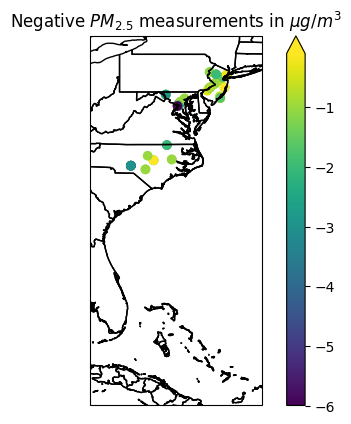

In [16]:
plot_with_geography(pm25[pm25['measurement']<0], satpass, title=r"Negative $PM_{2.5}$ measurements in $\mu g / m^3$")

In [17]:
pm25[pm25['measurement'] < 0].describe()

,longitude,latitude,time,measurement
count,81.000000,81.000000,81,81.000000
mean,-76.279886,38.864130,2024-03-24 14:44:26.666666496,-1.556790
min,-79.836636,35.041416,2024-03-24 05:00:00,-6.000000
25%,-77.360126,38.894770,2024-03-24 09:00:00,-2.000000
50%,-76.878333,39.363260,2024-03-24 14:00:00,-1.000000
75%,-74.448736,40.222411,2024-03-24 20:00:00,-0.800000
max,-74.036218,40.924580,2024-03-25 04:00:00,-0.100000
std,1.813013,1.850926,NaN,1.287433


Drop the null values and retain only non-negative $PM_{2.5}$ values.

In [18]:
pm25_clean = pm25[pm25['measurement'] >= 0].dropna()

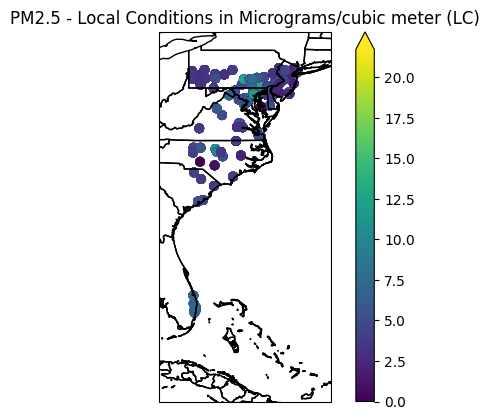

In [19]:
plot_with_geography(pm25_clean, satpass)

Note that the sensors in Florida (as an obvious example) are outside of the
swath that we originally showed. That's because we got sensor data from the API
by using a grid-aligned bounding box that contains the swath. Those Florida
sensors are within the most extreme latitude and longitude values of the swath.
Later, we get all the satellite data that is spatially near a sensor.

## Temporally Align $PM_{2.5}$ Data with Satellite Data

The `align_temporally()` method is one of the added features to the
`SampleDataFrame`. It chooses all observations in a data set that are closest
(by absolute difference) to the specified time. The resulting data set has a
single observation per sensor in the input data set.

In [20]:
aligned = pm25_clean.align_temporally(satpass.start, groupby="site_id")
aligned

,site_id,longitude,latitude,time,measurement,delta_t
429,0001,-79.836636,35.263165,2024-03-24 18:00:00,6.0,0 days 00:15:46
237,0002,-75.797317,39.305021,2024-03-24 18:00:00,3.0,0 days 00:15:46
165,0003,-75.864771,39.702982,2024-03-24 18:00:00,3.0,0 days 00:15:46
357,0004,-76.141006,38.587525,2024-03-24 18:00:00,2.0,0 days 00:15:46
645,0005,-74.742613,40.283092,2024-03-24 18:00:00,0.0,0 days 00:15:46
...,...,...,...,...,...,...
189,3001,-77.106876,39.114313,2024-03-24 18:00:00,1.0,0 days 00:15:46
2568,3007,-79.885331,40.294341,2024-03-24 18:00:00,2.7,0 days 00:15:46
1414,5005,-80.176389,26.294167,2024-03-24 18:00:00,6.1,0 days 00:15:46
1222,5200,-80.243995,40.268963,2024-03-24 18:00:00,2.8,0 days 00:15:46


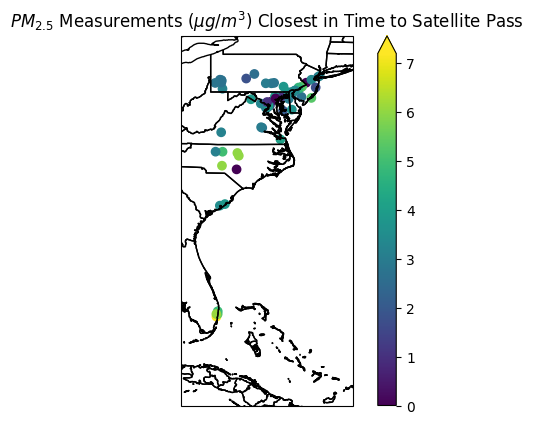

In [21]:
plot_with_geography(aligned, satpass, title=r"$PM_{2.5}$ Measurements $(\mu g / m^3)$ Closest in Time to Satellite Pass")

# Clean the AOT data

Before we can join the AOT data and the $PM_{2.5}$ data, we need to clean the
AOT data. Here, we flatten the latitude and longitude. Doing that makes the data
wrangling easier, but we run into problems with the contourf plot later.

In [22]:
import pandas as pd
def flatten(sat):
    data = {
        "latitude": sat.data['geolocation_data/latitude'].to_numpy().flatten(),
        "longitude": sat.data['geolocation_data/longitude'].to_numpy().flatten(),
        "aot": sat.data['geophysical_data/aot550'].to_numpy().flatten()
    }
    return pd.DataFrame(data)
aotdf = flatten(satpass)
aotdf

,latitude,longitude,aot
0,22.760002,-75.299637,NaN
1,22.770235,-75.250214,NaN
2,22.780453,-75.200790,NaN
3,22.790653,-75.151352,NaN
4,22.800840,-75.101913,NaN
...,...,...,...
11450,41.071041,-78.886505,NaN
11451,41.081749,-78.826271,NaN
11452,41.092430,-78.766014,NaN
11453,41.103077,-78.705734,NaN


In [23]:
#aotdf = df[df['aot'].notnull()]
aotdf.dropna(inplace=True)
aotdf

,latitude,longitude,aot
7257,34.305866,-77.914413,0.058702
7258,34.316654,-77.859436,0.053306
7259,34.327419,-77.804443,0.063261
7260,34.338158,-77.749443,0.064218
7286,34.351749,-77.927505,0.058300
...,...,...,...
11444,41.006119,-79.247513,0.047516
11445,41.017017,-79.187401,0.051405
11446,41.027885,-79.127258,0.049381
11447,41.038719,-79.067101,0.059815


## Join Satellite AOT to Ground-based $PM_{2.5}$

The `get_spatial_value()` method is the other significant addition to
`SampleDataFrame`s over a Pandas `DataFrame`. For each row in the current data
frame, it computes a value that is based a column in another frame. The computed
value is the mean value, averaged over all latitudes and longitudes that are
"near" the observation in the current frame. A point in the other data frame is
"near" the current observation if it is within plus or minus a specified number of degrees latitude and longitude of the point. 

In this case, we start with the $PM_{2.5}$ data frame, which has one row per sensor. When we run `get_spatial_value()` with the AOT data frame and `buffer=0.25`, it computes the average AOT within 0.25 degrees north, south, east, and west of the sensor.

In [24]:
aligned['aot']=aligned.get_spatial_value(aotdf, "aot", buffer=0.25)
final=aligned[aligned['aot'].notnull()]

In [25]:
final

,site_id,longitude,latitude,time,measurement,delta_t,aot
862,0008,-79.960757,40.465420,2024-03-24 18:00:00,2.7,0 days 00:15:46,0.044434
1534,0064,-79.868062,40.323768,2024-03-24 18:00:00,2.6,0 days 00:15:46,0.042175
2423,0524,-79.805499,39.917663,2024-03-24 18:00:00,3.2,0 days 00:15:46,0.047477
2399,1301,-79.860973,40.402328,2024-03-24 18:00:00,2.9,0 days 00:15:46,0.042818
958,1376,-79.863572,40.437430,2024-03-24 18:00:00,2.7,0 days 00:15:46,0.043924
2568,3007,-79.885331,40.294341,2024-03-24 18:00:00,2.7,0 days 00:15:46,0.041488


### After all that, why are there so few data points?

Well, we'd expect a lot of the sensors to be thrown away because they are outside of the swath. The narrower and more angled the swath is relative to the grid, the higher proportion of sensors thrown away. (See the Appendix.)

There's also missing data within swaths. There are quality indicators in the satellite data, but because this notebook is run on preliminary data, we don't have access to it yet. For example, we can't tell how much data was removed due 
to cloud contamination.

These final data points are satellite data that have valid measurements within
0.25 lat/lon of a sensor.

# Loop over satellite data to build a data set

Recall that we did our investigation with a single satellite pass, but we had downloaded much more. Now that we know what cleaning steps we need to take, let's create a loop to create a data set with many more satellite passes.

These are the same data cleaning steps as before, but we append all the final results into a single data frame stored in the variable `main`.


In [26]:
# Initialize accumulator DataFrame
#api=AqsClient.from_netrc()
dataframes = []
for swath in passes:
    pm25=api.get_pollutant_in_swath(AqiPollutant.PM25, swath)
    pm25.dropna(inplace=True)
    cleaned=pm25[pm25['measurement'] >= 0].dropna()
    aligned=cleaned.align_temporally(swath.start, groupby="site_id")
    # Flatten satellite dataframe
    flat=flatten(swath)
    aligned['aot']=aligned.get_spatial_value(flat, 'aot')
    final=aligned[aligned['aot'].notnull()]
    # Append to Accumulating dataframe
    dataframes.append(final)

In [27]:
main = pd.concat(dataframes,ignore_index=True)

In [28]:
main

,site_id,longitude,latitude,time,measurement,delta_t,aot
0,0008,-79.960757,40.465420,2024-03-24 18:00:00,2.7,0 days 00:15:46,0.044434
1,0064,-79.868062,40.323768,2024-03-24 18:00:00,2.6,0 days 00:15:46,0.042175
2,0524,-79.805499,39.917663,2024-03-24 18:00:00,3.2,0 days 00:15:46,0.047477
3,1301,-79.860973,40.402328,2024-03-24 18:00:00,2.9,0 days 00:15:46,0.042818
4,1376,-79.863572,40.437430,2024-03-24 18:00:00,2.7,0 days 00:15:46,0.043924
...,...,...,...,...,...,...,...
59,1301,-79.860973,40.402328,2024-06-28 18:00:00,7.7,0 days 00:14:33,0.096602
60,1376,-79.863572,40.437430,2024-06-28 18:00:00,6.2,0 days 00:14:33,0.098475
61,3007,-79.885331,40.294341,2024-06-28 18:00:00,6.3,0 days 00:14:33,0.095687
62,0013,-79.802314,36.109006,2025-01-08 18:00:00,4.0,0 days 00:07:44,0.064764


# Model and Plot

Keeping it simple, let's look at a linear regression plot between AOT and $PM_{2.5}$.

In [29]:
import sklearn
reg = sklearn.linear_model.LinearRegression()
reg.fit(main['aot'].to_frame(), main['measurement'])
print(reg.coef_)
print(reg.intercept_)

[21.83029679]
2.804536258409497


In [30]:
predicted=reg.predict(main['aot'].to_frame())
r2=sklearn.metrics.r2_score(main['measurement'], predicted)
r2

0.3673640121083761

(0.0, 19.9)

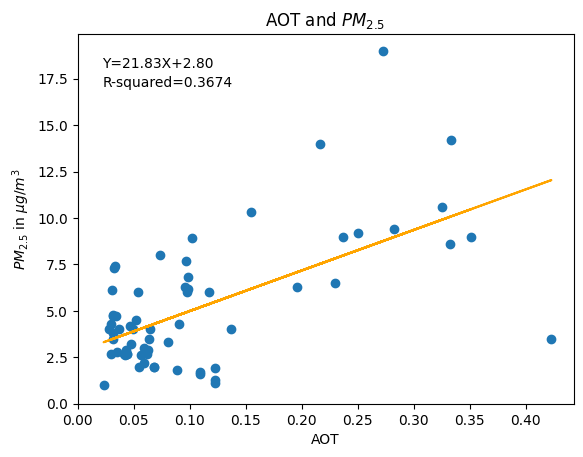

In [31]:
fig = plt.figure()
ax = plt.subplot(111)
ax.scatter(main['aot'], main['measurement'])
ax.plot(main['aot'], predicted, color="orange")
ax.set_title(r"AOT and $PM_{2.5}$ ")
ax.set_xlabel(r"AOT")
ax.set_ylabel(r"$PM_{2.5}$ in $\mu g / m^3$")
ax.text(
    0.05,0.9,
    f"Y={reg.coef_[0]:2.2f}X+{reg.intercept_:2.2f}",
    verticalalignment="bottom",
    horizontalalignment="left",
    transform=ax.transAxes,
    )
ax.text(
    0.05,0.85,
    f"R-squared={r2:.4f}",
    verticalalignment="bottom",
    horizontalalignment="left",
    transform=ax.transAxes,
)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# Appendix: Satellite Data that is near Sensors

This is where flattening the latitude and longitude of the satelite data becomes
a problem. To plot over an area, you should use the `contourf` plot. But that
expects 2-D arrays for input. Since we flattened latitude and longitude, the `contourf` plotting function doesn't work. I made a scatterplot, which kinda works - it still displays latitude x longitude x measurment. But it looks gross with overlapping markers.

The `contourf` examples that go from 1-D arrays to 2-D arrays tend to use `np.meshgrid()`. Hmm... That might work. Originally, I'd thought that wouldn't work because we don't have an even grid. By that, I mean we don't have a measurement for each point on the latitude, longitude lattice that `meshgrid()` would create. But so what? We'll just have a lot of zeros.

In [32]:
# "near" is defined by data that is within +/- 0.25 degrees of lat/lon of a sensor
from functools import partial
def is_near_points(row, buffer=0.25, points_df=None):
    lat=abs(points_df['latitude'] - row['latitude']) < buffer
    lon=abs(points_df['longitude']- row['longitude']) < buffer
    return (lat & lon).any()

# Is there a way to hide "partial" from end users?
is_near_sensor=partial(is_near_points, points_df=pm25)

In [33]:
row={'latitude':34.5, 'longitude':-77.9}
is_near_points(row, points_df=pm25)

np.True_

In [34]:
aotdf.apply(is_near_sensor,axis=1)

7257      True
7258      True
7259      True
7260      True
7286      True
         ...  
11444    False
11445    False
11446    False
11447    False
11448    False
Length: 2484, dtype: bool

In [35]:
near=aotdf[aotdf.apply(is_near_sensor,axis=1)]

In [36]:
near

,latitude,longitude,aot
7257,34.305866,-77.914413,0.058702
7258,34.316654,-77.859436,0.053306
7259,34.327419,-77.804443,0.063261
7260,34.338158,-77.749443,0.064218
7286,34.351749,-77.927505,0.058300
...,...,...,...
9733,38.312099,-78.421730,0.029881
9734,38.322781,-78.363838,0.045939
9757,38.303963,-78.724739,0.048564
9758,38.314789,-78.666893,0.051869


In [37]:
def plot2_with_geography(data, swath):
    fig = plt.figure()
    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent(swath.bbox.to_extent(buffer=2)) 
    ax.add_feature(cfeature.STATES)
    # contourf expects z to be 2d, so instead we use scatter even though it's gross
    #myplot=ax.contour(data['longitude'], data['latitude'], data['aot'])
    myplot=ax.scatter(data['longitude'], data['latitude'], c=data['aot'])
    ax.set_title(f"AOD on {swath.start.date()}")
    fig.colorbar(myplot, extend="max")

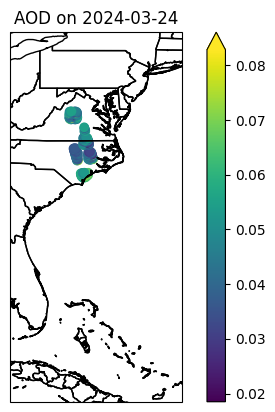

In [38]:
plot2_with_geography(near, satpass)

Note now that the plotted AOT data resides entirely within the swath.